#Main settings

In [107]:
if_train = False
if_wandb = False
if_download_parameters = True
if_save_model = False
if_show_example = True
if_confusion_matrix = True

MAX_EPOCHS=35
BATCH_SIZE=64
LEARNING_RATE=0.001

#Instal modules

In [108]:
!pip install gdown --quiet
!pip install lightning --quiet
!pip install wandb --quiet
!pip install pytorch-lightning==1.9.4 --quiet
!pip install mlxtend==0.21
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Import modules

In [109]:
import gdown
import os
import zipfile
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import mlxtend
import torchmetrics
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import wandb

from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix
from torchvision import datasets, transforms
from torchvision.transforms import (
    Compose, 
    Resize, 
    Normalize, 
    ToTensor, 
    RandomVerticalFlip, 
    RandomHorizontalFlip, 
    RandomPerspective,
    ToPILImage
)


from mlxtend.plotting import plot_confusion_matrix
from typing import Tuple, Dict, List
from IPython.display import FileLink
from tqdm.auto import tqdm

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from lightning.pytorch.loggers import TensorBoardLogger

#Model implementation

In [110]:
class InvResidual(nn.Module):
    def __init__(self, inp, output, stride, expand_ratio):
        super().__init__()
        dimension_number = int(expand_ratio*inp)
             
        if expand_ratio != 1:
           self.conv = nn.Sequential(
              nn.Conv2d(inp, dimension_number, 1, 1, 0, bias=False),
              nn.BatchNorm2d(dimension_number),
              nn.ReLU6(inplace=True),
              nn.Conv2d(
                  dimension_number, dimension_number, 3, stride, 1, groups=dimension_number, bias=False),
              nn.BatchNorm2d(dimension_number),
              nn.ReLU6(inplace=True),
              nn.Conv2d(dimension_number, output, 1, 1, 0, bias=False),
              nn.BatchNorm2d(output),
            )
        
        else:
           self.conv = nn.Sequential(
              nn.Conv2d(
                  dimension_number, dimension_number, 3, stride, 1, groups=dimension_number, bias=False),
              nn.BatchNorm2d(dimension_number),
              nn.ReLU6(inplace=True),
              nn.Conv2d(dimension_number, output, 1, 1, 0, bias=False),
              nn.BatchNorm2d(output),
            )
           
        self.if_residual_connection = False
        if (stride == 1 and inp == output):
            self.if_residual_connection = True

    def forward(self, x):
        res = self.conv(x)
        if (self.if_residual_connection):
            res += x
        return res

class MobileNetV2(nn.Module):
    def __init__(self, n_class=5, input_size=224):
        super().__init__()
        
        inv_residuals_matrix = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]
     
        self.last_channel = 1280
        input_channel = 32
        self.features = []
        
        self.features.append(nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)))
             
        for t, c, n, s in inv_residuals_matrix:
            output_channel = c
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(InvResidual(
                    input_channel, 
                    output_channel, 
                    stride, 
                    expand_ratio=t))            
                input_channel = output_channel
             
        self.features.append(nn.Sequential(
            nn.Conv2d(input_channel, self.last_channel, 1, 1, 0, bias=False), 
            nn.BatchNorm2d(self.last_channel),
            nn.ReLU6(inplace=True)
        ))
        
        self.features.append(nn.AvgPool2d(kernel_size=input_size//32, stride=1))
        self.features = nn.Sequential(*self.features)
        self.classifier = nn.Linear(self.last_channel, n_class)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

# Data Module

In [111]:
class TrashDataModule(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.image_size = (224, 224)
        self.num_classes = 5

        self.num_workers = os.cpu_count()
        self.ifrun = False
        
    def prepare_data(self):
        if self.ifrun:
            return

        url = "https://drive.google.com/uc?id=10RV4Weu1YGnaQ42EqXhWP1lIAaFFkFcw"
        output = "dataset.zip"
        gdown.download(url, output, quiet=False)
        z  = zipfile.ZipFile(output)
        z.extractall()

    def setup(self, stage=None):
        if self.ifrun:
            return
        self.ifrun = True
        
        self.train_dataset = datasets.ImageFolder(
            root="trash_dataset/train", 
            transform=self.get_train_transform()
        )
        
        self.test_dataset = datasets.ImageFolder(
            root="trash_dataset/test", 
            transform=self.get_test_transform()
        )
        
        self.val_dataset = datasets.ImageFolder(
            root="trash_dataset/validate", 
            transform=self.get_test_transform()
        )

    def get_train_transform(self):
        return Compose([
            Resize(self.image_size),
            RandomPerspective(p=0.2),
            RandomHorizontalFlip(p=0.3),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def get_test_transform(self):
        return Compose([
            Resize(self.image_size),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def val_dataloader(self):
         return DataLoader(
            dataset=self.val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

# Lightning Module

In [112]:
class MobileNetClassifier(pl.LightningModule):

    def __init__(self, learning_rate=0.001, num_classes=5):
        super().__init__()
        self.model = MobileNetV2()
        self.lr = learning_rate
        self.num_classes = num_classes
        self.current_epoch_training_loss = torch.tensor(0.0)

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, x, y): 
        return F.cross_entropy(x, y)

    def common_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.compute_loss(outputs,y)
        return loss, outputs, y

    def common_test_valid_step(self, batch, batch_idx):
        loss, outputs, y = self.common_step(batch, batch_idx)
        preds = torch.argmax(outputs, dim=1)
        acc = torchmetrics.functional.accuracy(preds, y, num_classes = self.num_classes, task="multiclass")
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _, _ = self.common_step(batch, batch_idx)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True) 
        return {'loss':loss}

    def validation_step(self, batch, batch_idx):
        loss, acc = self.common_test_valid_step(batch, batch_idx)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)        
        return {'val_loss':loss, 'val_acc': acc}

    def test_step(self, batch, batch_idx):
        loss, acc = self.common_test_valid_step(batch, batch_idx)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return {'test_loss': loss, 'test_acc': acc}

    def configure_optimizers(self):
        optimizer =  torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-5) 
        return optimizer

In [113]:
dm=TrashDataModule(BATCH_SIZE)
dm.prepare_data()
dm.setup()

Downloading...
From: https://drive.google.com/uc?id=10RV4Weu1YGnaQ42EqXhWP1lIAaFFkFcw
To: /content/dataset.zip
100%|██████████| 245M/245M [00:02<00:00, 114MB/s]


#Trainer initialization

In [114]:
model = MobileNetClassifier()

logger = None
if if_wandb:
    wandb.login()
    logger = WandbLogger(project='mobilenet-wandb', job_type='train')
    
else:
    logger = TensorBoardLogger("logs", name="mobilenetmodel") 

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=False,
    mode='min')

MODEL_CKPT_PATH = 'model/'
MODEL_CKPT = 'model-{epoch:02d}-{val_acc:.2f}'

checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath=MODEL_CKPT_PATH,
    filename=MODEL_CKPT,
    save_top_k=3,
    mode='max'
)
    
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS, 
    accelerator='auto', 
    devices='auto',
    logger=logger,
    callbacks=[checkpoint_callback,early_stop_callback]
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


#Model training

In [115]:
if if_train:
    trainer.fit(model=model, datamodule=dm)
    trainer.test(model=model, datamodule=dm)
    
    if if_wandb:
        wandb.finish()

In [116]:
if not if_wandb and if_train:
  %load_ext tensorboard

In [117]:
if not if_wandb and if_train:
  %tensorboard --logdir run

#Saving parameters

In [118]:
if if_save_model:
    !zip -r model.zip ./model
    FileLink(r'model.zip')

#Parameters download

In [119]:
if if_download_parameters:
    url = "https://drive.google.com/uc?id=1DyBL6WdiCvD0717Xa2X0fwFthkSbyz5N"
    output = "params.zip"
    gdown.download(url, output, quiet=False)
    z  = zipfile.ZipFile(output)
    z.extractall()
    if torch.cuda.is_available():
      checkpoint = torch.load("parameters/model-epoch=17-val_acc=0.87.ckpt")
    else:
      checkpoint = torch.load(
          "parameters/model-epoch=17-val_acc=0.87.ckpt", 
          map_location=torch.device('cpu'))
      
    model.load_state_dict(checkpoint['state_dict'])
    
    trainer.test(model=model, datamodule=dm)

Downloading...
From: https://drive.google.com/uc?id=1DyBL6WdiCvD0717Xa2X0fwFthkSbyz5N
To: /content/params.zip
100%|██████████| 74.6M/74.6M [00:00<00:00, 107MB/s]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8584192395210266     │
│      test_loss_epoch      │    0.4113255739212036     │
└───────────────────────────┴───────────────────────────┘

# Example predictions

In [120]:
def make_predictions(model, data, device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample.to(device))  
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) 
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [121]:
def show_example():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  test_samples = []
  test_labels = []
  for sample, label in random.sample(list(dm.test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)
    pred_probs= make_predictions(model=model, data=test_samples, device=device)
    pred_classes = pred_probs.argmax(dim=1)

  plt.figure(figsize=(9, 9))
  nrows = 3
  ncols = 3
  for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
      
    inv_imagenet_normalize = Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1./0.229, 1./0.224, 1./0.225])
    sample = inv_imagenet_normalize(sample)
    sample = sample.swapaxes(0, 1)
    sample = sample.swapaxes(1, 2)
    plt.imshow(sample.squeeze())
    pred_label = dm.test_dataset.classes[pred_classes[i]]
    truth_label = dm.test_dataset.classes[test_labels[i]] 

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") 
    else:
      plt.title(title_text, fontsize=10, c="r")
      #plt.axis(False);


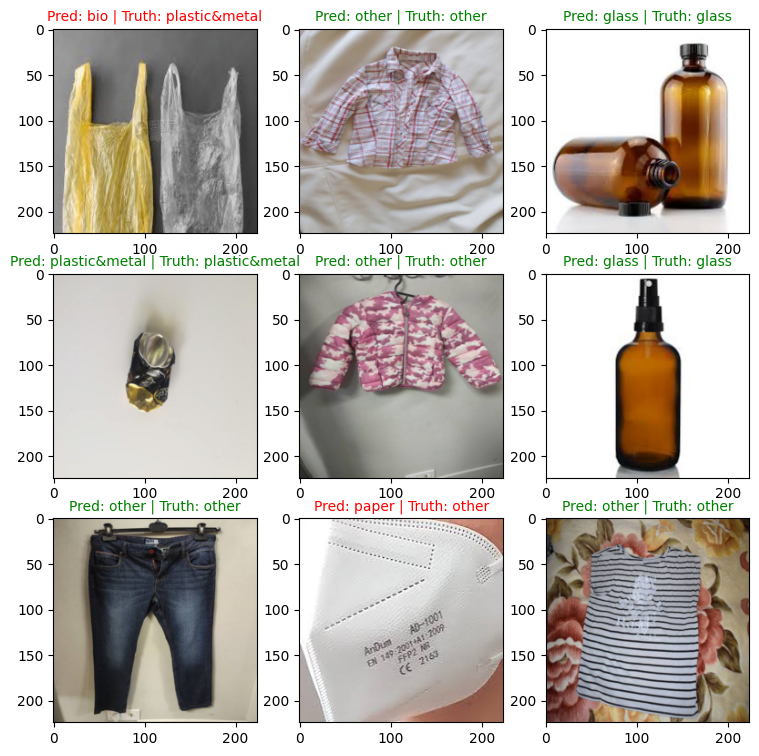

In [122]:
if if_show_example:
  show_example()

#Confusion matrix

In [123]:
def column(matrix, i):
    return [row[i] for row in matrix]

def run_confusion_matrix():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  y_preds = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(dm.test_dataloader(), desc="Making predictions"):
      X, y = X.to(device), y.to(device)
      y_logit = model(X)
      y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
      y_preds.append(y_pred.cpu())
  y_pred_tensor = torch.cat(y_preds)

  targets = column(list(dm.test_dataset),1)

  confmat = ConfusionMatrix(num_classes=len(dm.test_dataset.classes), task='multiclass')
  confmat_tensor = confmat(preds=y_pred_tensor, target=torch.Tensor(targets))

  fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), 
    class_names=dm.test_dataset.classes, # turn the row and column labels into class names
    show_normed=True,
    show_absolute=False,
    figsize=(10, 7)
  );

Making predictions:   0%|          | 0/23 [00:00<?, ?it/s]

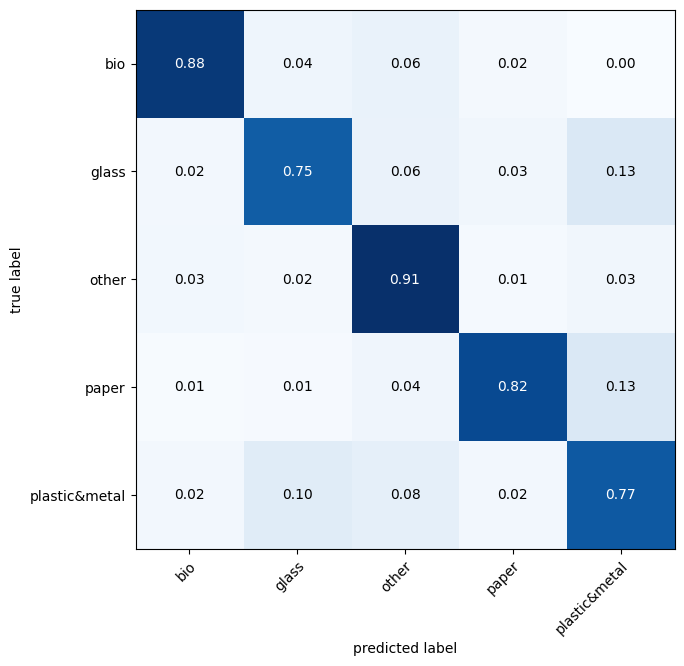

In [124]:
if if_confusion_matrix:
  run_confusion_matrix()